In [8]:
import sys
sys.path.append('../')
import pystan
import stan_utility

import arviz as az
import matplotlib.pyplot as plt

import numpy as np
import scipy.stats as stats

import pandas as pd
import matplotlib as mpl

In [9]:
light="#FFFCDC"
light_highlight="#FEF590"
mid="#FDED2A"
mid_highlight="#f0dc05"
dark="#EECA02"
dark_highlight="#BB9700"
green="#00FF00"
light_grey="#DDDDDD"

plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200

In [10]:
#1 Gamma family distributions

In [21]:
with open('gamma.stan', 'r') as file:
    print(file.read())

data {
    int alfa;
    int beta;
}

generated quantities {
    real theta = gamma_rng(alfa,beta);
    real theta_inv = inv_gamma_rng(alfa,beta);
}


In [56]:
model_prior=stan_utility.compile_model('gamma.stan')

Using cached StanModel


In [57]:
R=1000
sim_data=dict(alfa=46, beta=6)
sim_ppc=model_prior.sampling(data=sim_data,algorithm="Fixed_param", iter=R, warmup=0, chains=1, refresh=R,
                             seed=30042020)

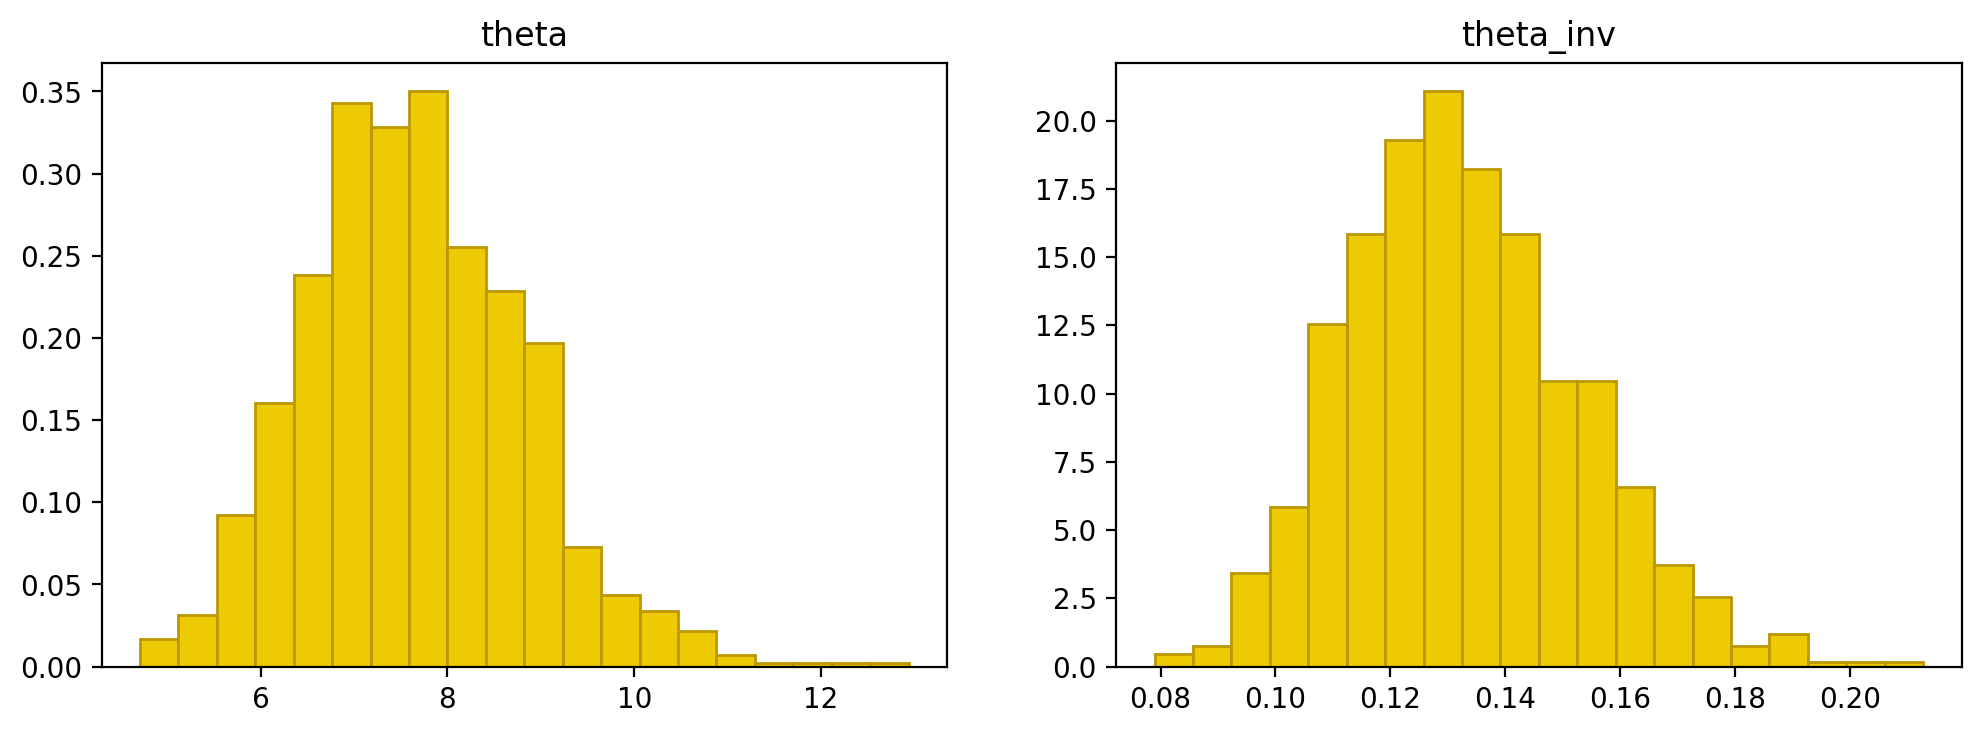

In [58]:
params=sim_ppc.extract()
theta=params['theta']
theta_inv=params['theta_inv']
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
ax1=axes[0]
ax1.hist(theta,color=dark,edgecolor=dark_highlight,density=True,bins=20)
ax1.set_title('theta')
ax2=axes[1]
ax2.hist(theta_inv,color=dark,edgecolor=dark_highlight,density=True,bins=20)
ax2.set_title('theta_inv')
plt.show()

In [15]:
#We can see shapes of gamma(left) and inverse gamma (right) distributions. I rerendered it with parameters from next step to compare gamma_rng to gamma generations.

In [16]:
with open('gamma_algebra_solver.stan', 'r') as file:
    print(file.read())

functions {
    vector tail_delta(vector y, vector theta, real[] x_r, int[] x_i) {
        vector[2] deltas;
        deltas[1] = gamma_cdf(theta[1], y[1], y[2]) - 0.99; //1%>10
        deltas[2] = gamma_cdf(theta[2], y[1], y[2]) - 0.01; //1%<5
        return deltas;
  }
}

data {
    vector<lower=0>[2] y_guess; // Initial guess of Gamma distribution
    vector<lower=0>[2] theta;   // Target quantile
}

transformed data {
    vector[2] y;
    real x_r[0];
    int x_i[0];

  // Find Gamma distribution parameters that ensures 98% probabilty between 5 and 10
  y = algebra_solver(tail_delta, y_guess, theta, x_r, x_i, 1e-10, 1e-3, 1e3);
  print("Alpha  = ", y[1]);
  print("Beta = ", y[2]);
}

generated quantities {
  real alpha = y[1];
  real beta = y[2];
}


In [18]:
model_prior=stan_utility.compile_model('gamma_algebra_solver.stan')

Using cached StanModel


In [19]:
#Using algebra solver to obtain alpha and beta for gamma distribution
data=dict(y_guess=np.array([1,0.1]),theta=np.array([10,5]))
sim_nm = model_prior.sampling(data=data,
                            seed=1052020,
                            algorithm="Fixed_param",
                            iter=1, 
                            warmup=0,
                            chains=1)

alpha = np.round(sim_nm.extract()['alpha'][0])
beta = np.round(sim_nm.extract()['beta'][0])

print('Alpha: {a}, Beta: {b}'.format(a=alpha, b=beta))

Alpha: 46.0, Beta: 6.0


In [39]:
# Parameters for gamma distribution to be in range between 5 and 100 with 985 propability equals: alpha = 46, beta = 6

In [83]:
with open('gamma2.stan', 'r') as file:
    print(file.read())

data {
    real<lower=0> alpha;
    real<lower=0> beta;
}

parameters {
    real y;
}

model {
    y ~ gamma(alpha, beta);
}


In [84]:
gamma_model=stan_utility.compile_model('gamma2.stan')

Using cached StanModel


Mean value : 7.682


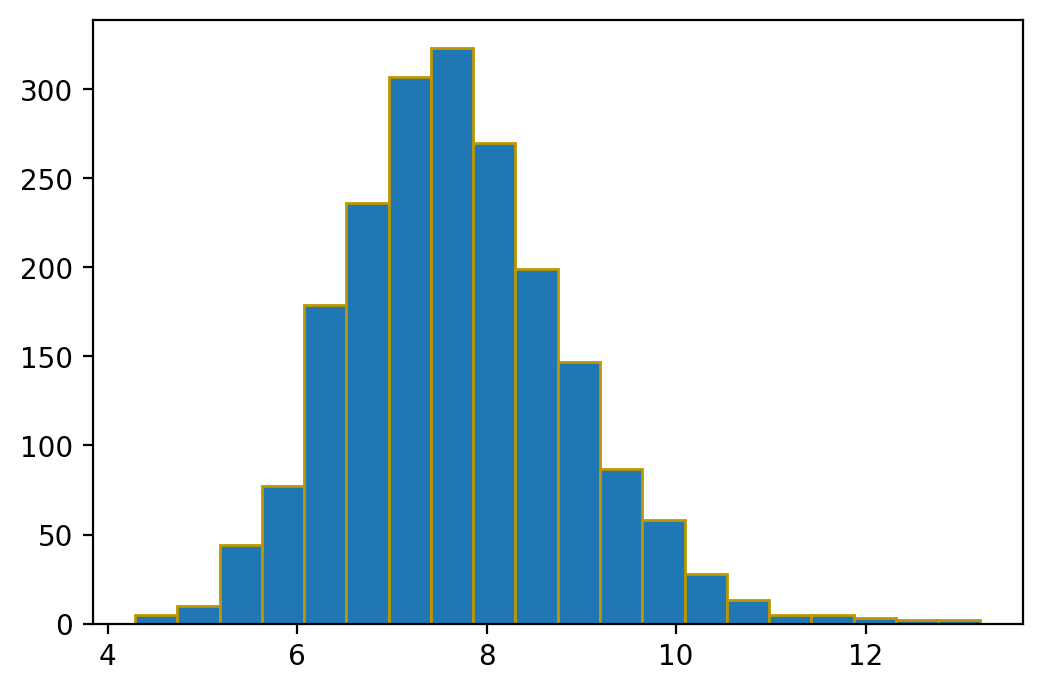

In [94]:
#Applying apropriate data and sampling
R=1000
sim_data=dict(alpha=46, beta=6)
sim_ppc=gamma_model.sampling(data=sim_data, iter=R, seed=30042020)

params=sim_ppc.extract()

hist1=plt.hist(params['y'],edgecolor=dark_highlight,bins=20)
mean = np.mean(params['y'])
print('Mean value : {:5.3f}'.format(mean))

In [86]:
#We can see that it looks quite well, most values are between 5 and 10
#Next is inverse gamma distribution

In [87]:
with open('inv_gamma_algebra_solver.stan', 'r') as file:
    print(file.read())

functions {
    vector tail_delta(vector y, vector theta, real[] x_r, int[] x_i) {
        vector[2] deltas;
        deltas[1] = inv_gamma_cdf(theta[1], y[1], y[2]) - 0.99; //1%>10
        deltas[2] = inv_gamma_cdf(theta[2], y[1], y[2]) - 0.01; //1%<5
        return deltas;
  }
}

data {
    vector<lower=0>[2] y_guess; // Initial guess of Gamma distribution
    vector<lower=0>[2] theta;   // Target quantile
}

transformed data {
    vector[2] y;
    real x_r[0];
    int x_i[0];

  // Find Gamma distribution parameters that ensures 98% probabilty between 5 and 10
  y = algebra_solver(tail_delta, y_guess, theta, x_r, x_i, 1e-10, 1e-3, 1e3);
  print("Alpha  = ", y[1]);
  print("Beta = ", y[2]);
}

generated quantities {
  real alpha = y[1];
  real beta = y[2];
}


In [88]:
inv_gamma_model=stan_utility.compile_model('inv_gamma_algebra_solver.stan')

Using cached StanModel


In [89]:
#Using algebra solver to obtain alpha and beta for inversegamma distribution
data=dict(y_guess=np.array([0.1,0.9]),theta=np.array([10,5]))
sim_nm = inv_gamma_model.sampling(data=data,
                            seed=1052020,
                            algorithm="Fixed_param",
                            iter=1, 
                            warmup=0,
                            chains=1)

alpha = np.round(sim_nm.extract()['alpha'][0])
beta = np.round(sim_nm.extract()['beta'][0])

print('Alpha: {a}, Beta: {b}'.format(a=alpha, b=beta))

Alpha: 46.0, Beta: 313.0


In [90]:
inv_gamma_model=stan_utility.compile_model('inv_gamma2.stan')

Using cached StanModel


Mean value : 7.016


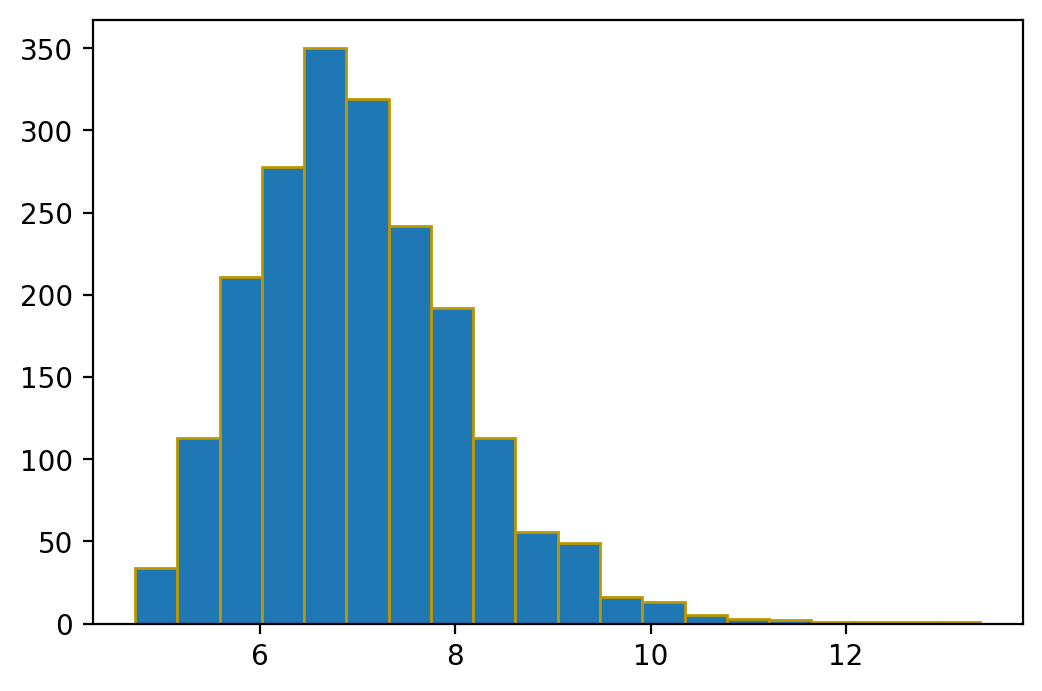

In [93]:
#Applying apropriate data and sampling
R=1000
sim_data=dict(alpha=46, beta=313)
sim_ppc=inv_gamma_model.sampling(data=sim_data, iter=R, seed=30042020)

params=sim_ppc.extract()

hist1=plt.hist(params['y'],edgecolor=dark_highlight,bins=20)

mean = np.mean(params['y'])
print('Mean value : {:5.3f}'.format(mean))

In [ ]:
#Again it looks well, most values are between 5 and 10 so i think that is ok

In [31]:
#2 Negative binomial distribution

In [105]:
with open('2_binomial_poisson.stan', 'r') as file:
    print(file.read())

data {
    real alfa;
    real beta;
    
}

generated quantities {
    real lambda = alfa;
    real y_binomial = neg_binomial_2_rng(alfa,beta);
    real y_poisson = poisson_rng(lambda);
}


In [106]:
model_prior=stan_utility.compile_model('2_binomial_poisson.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0ffab09150a41118481092b29cc227c0 NOW.


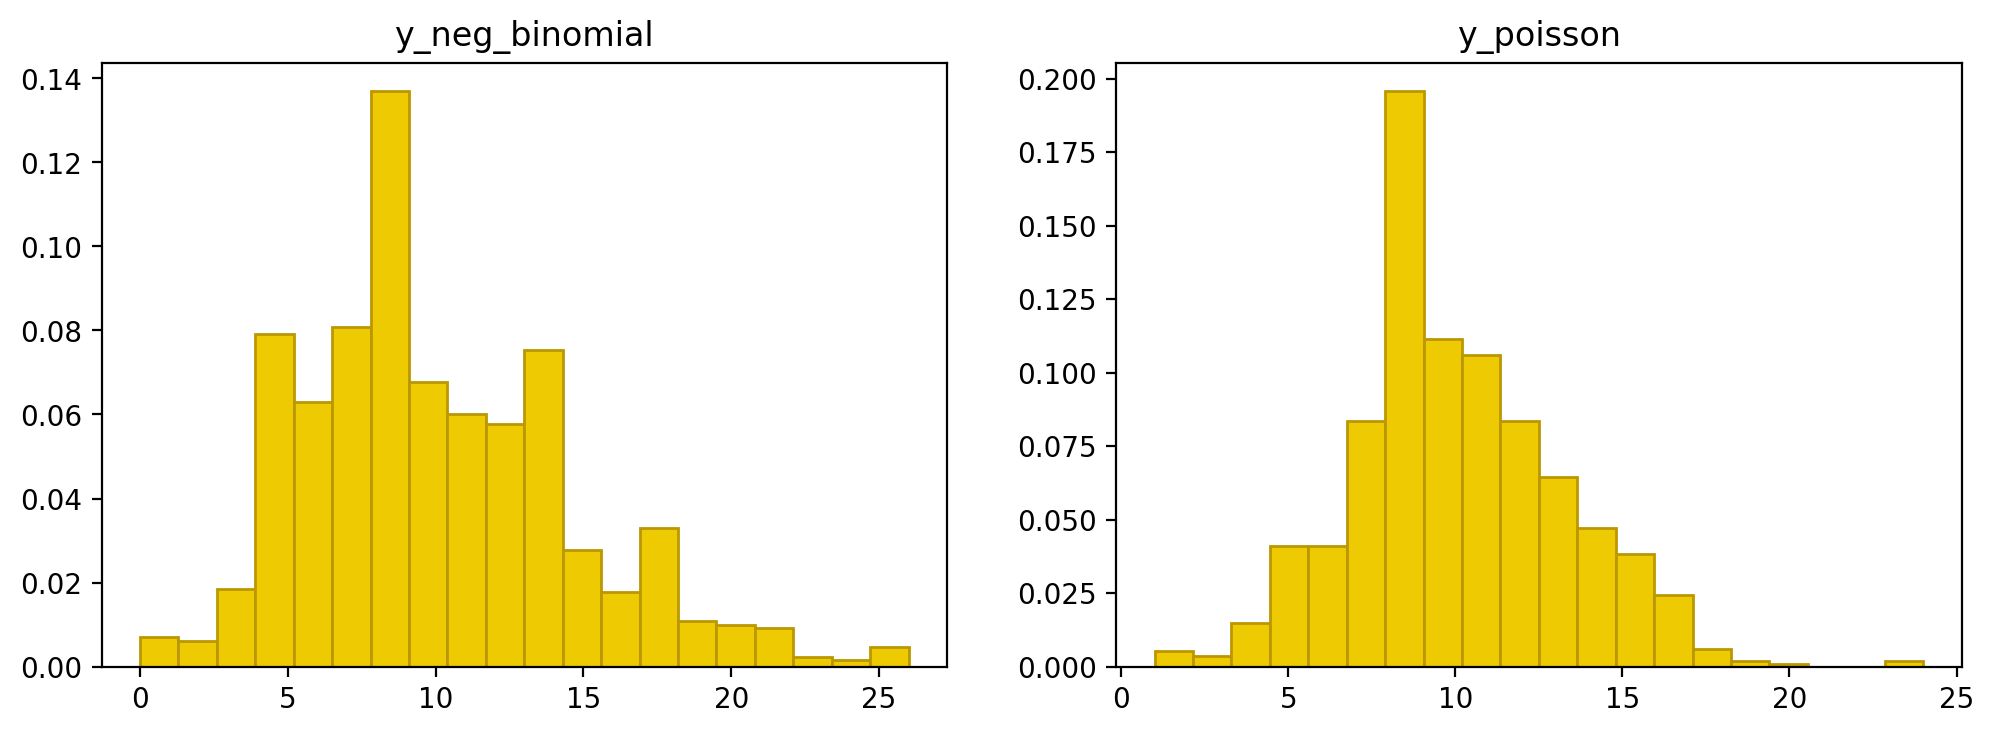

In [114]:
# Bellow are simulationf for different parameters
R=1000
alfa = 10
beta = 10
sim_data=dict(alfa=alfa, beta=beta)
sim_ppc=model_prior.sampling(data=sim_data,algorithm="Fixed_param", iter=R, warmup=0, chains=1, refresh=R,
                             seed=30042020)

params=sim_ppc.extract()
y_binomial=params['y_binomial']
y_poisson=params['y_poisson']

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
ax1=axes[0]
ax1.hist(y_binomial,color=dark,edgecolor=dark_highlight,density=True,bins=20)
ax1.set_title('y_neg_binomial')
ax2=axes[1]
ax2.hist(y_poisson,color=dark,edgecolor=dark_highlight,density=True,bins=20)
ax2.set_title('y_poisson')
plt.show()

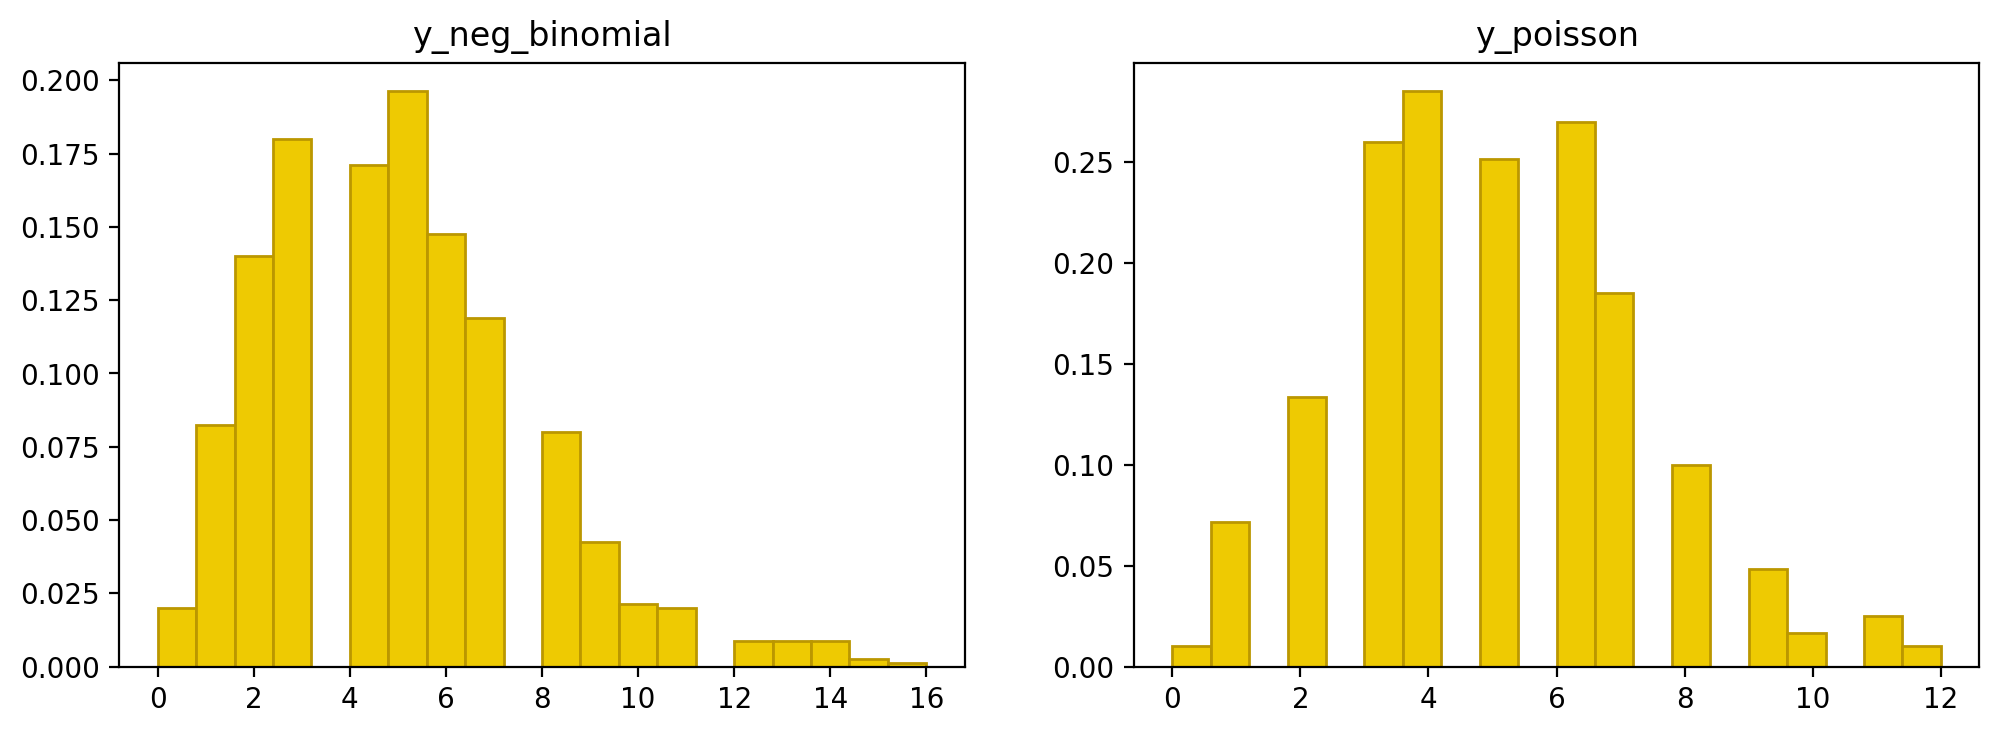

In [115]:
R=1000
alfa = 5
beta = 10
sim_data=dict(alfa=alfa, beta=beta)
sim_ppc=model_prior.sampling(data=sim_data,algorithm="Fixed_param", iter=R, warmup=0, chains=1, refresh=R,
                             seed=30042020)

params=sim_ppc.extract()
y_binomial=params['y_binomial']
y_poisson=params['y_poisson']

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
ax1=axes[0]
ax1.hist(y_binomial,color=dark,edgecolor=dark_highlight,density=True,bins=20)
ax1.set_title('y_neg_binomial')
ax2=axes[1]
ax2.hist(y_poisson,color=dark,edgecolor=dark_highlight,density=True,bins=20)
ax2.set_title('y_poisson')
plt.show()

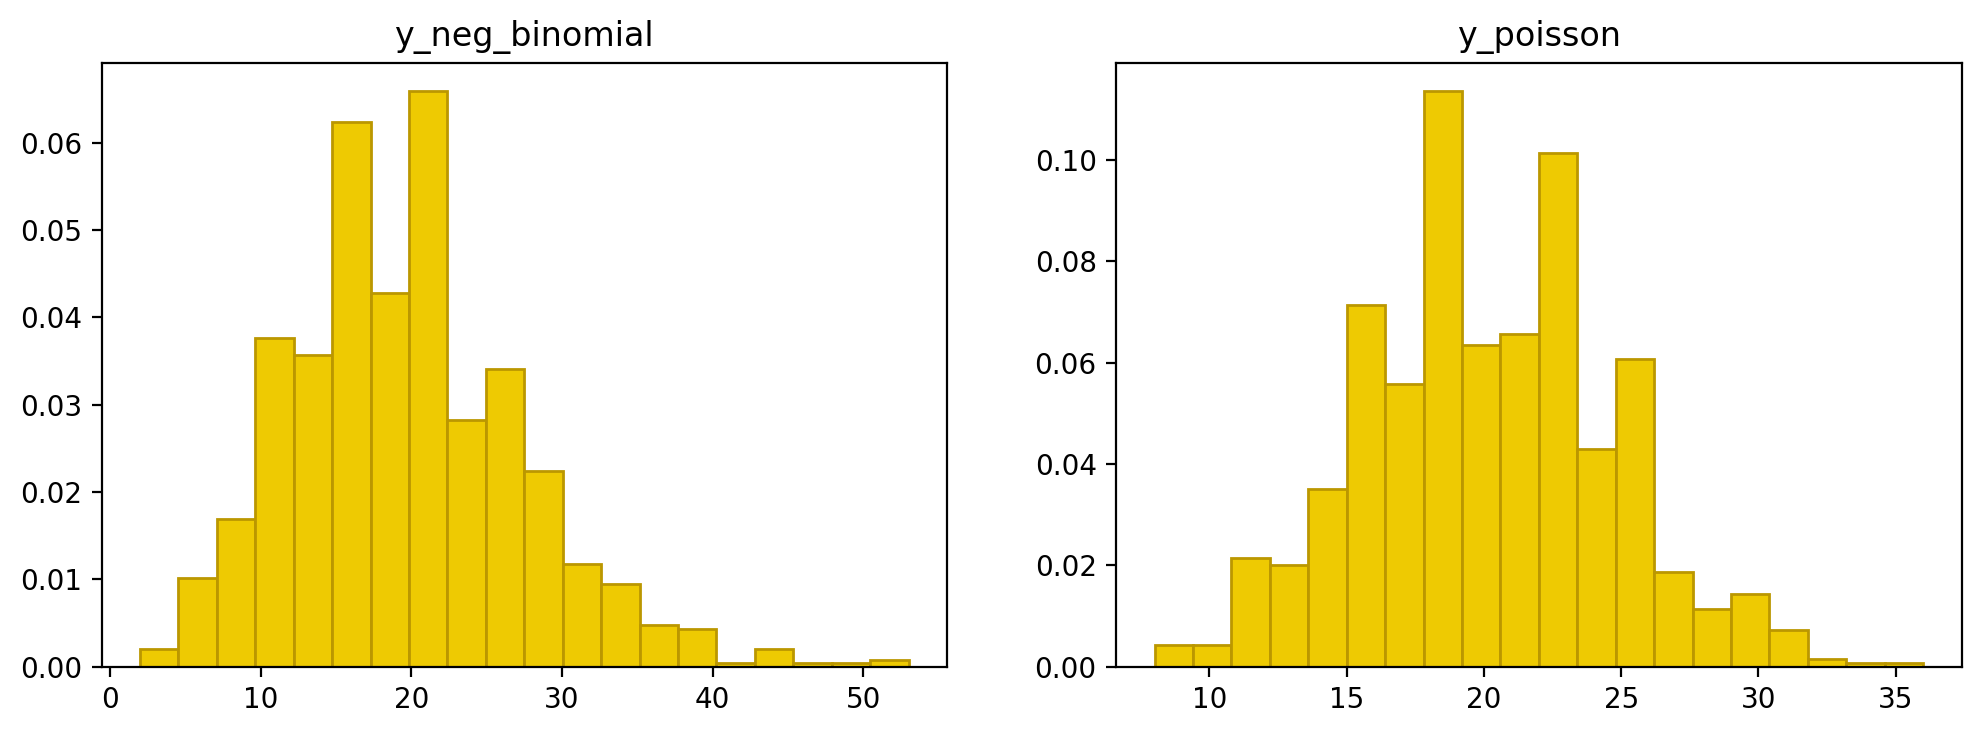

In [116]:
R=1000
alfa = 20
beta = 10
sim_data=dict(alfa=alfa, beta=beta)
sim_ppc=model_prior.sampling(data=sim_data,algorithm="Fixed_param", iter=R, warmup=0, chains=1, refresh=R,
                             seed=30042020)

params=sim_ppc.extract()
y_binomial=params['y_binomial']
y_poisson=params['y_poisson']

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
ax1=axes[0]
ax1.hist(y_binomial,color=dark,edgecolor=dark_highlight,density=True,bins=20)
ax1.set_title('y_neg_binomial')
ax2=axes[1]
ax2.hist(y_poisson,color=dark,edgecolor=dark_highlight,density=True,bins=20)
ax2.set_title('y_poisson')
plt.show()

In [ ]:
# According to https://mc-stan.org/docs/2_23/functions-reference/nbalt.html those parametrization should differ by variande(of neg_binomial) = mean^2/variance but I don't see that

In [ ]:
# Student-t family distributions.

In [120]:
with open('3_student_t_cauchy.stan', 'r') as file:
    print(file.read())

data {
    real nu;
    real mu;
    real sigma; 
}

generated quantities {
    real y_student_t = student_t_rng(nu, mu, sigma);
    real y_normal = normal_rng(mu, sigma);
    real y_cauchy = cauchy_rng(mu, sigma);
}


In [121]:
model_prior=stan_utility.compile_model('3_student_t_cauchy.stan')

Using cached StanModel


In [122]:
R=1000
nu = 1 #degree
mu = 10 #mean
sigma = 1 #variance
sim_data=dict(nu = nu, mu = mu, sigma = sigma)
sim_ppc=model_prior.sampling(data=sim_data,algorithm="Fixed_param", iter=R, warmup=0, chains=1, refresh=R,
                             seed=30042020)

In [123]:
params=sim_ppc.extract()
y_student_t=params['y_student_t']
y_normal=params['y_normal']
y_cauchy=params['y_cauchy']

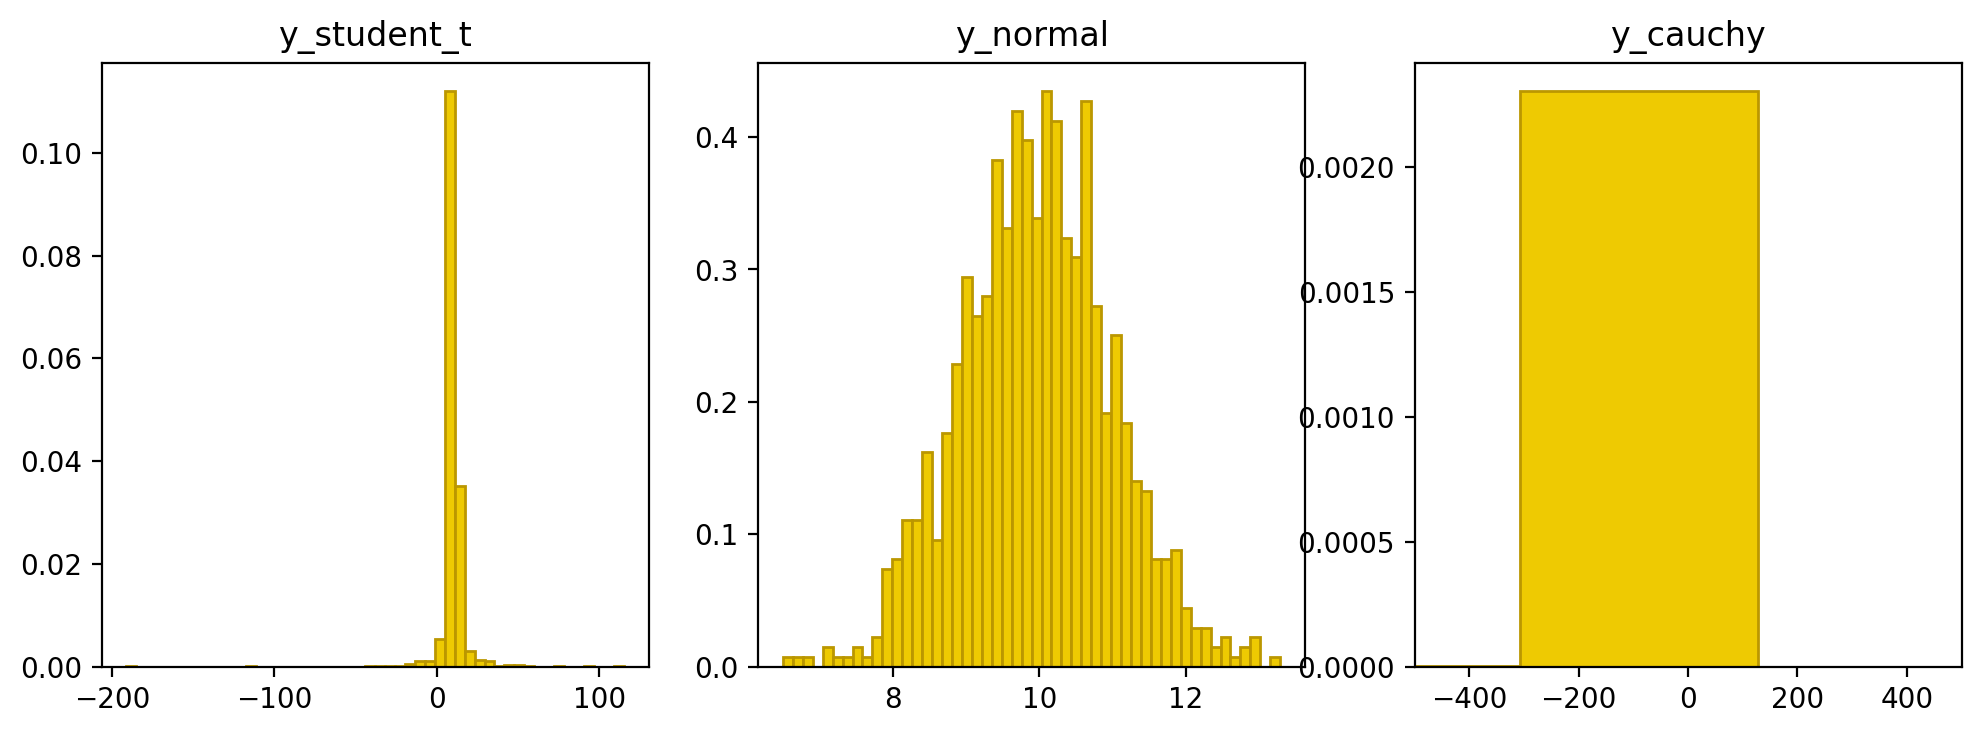

In [124]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
ax1=axes[0]
ax1.hist(y_student_t,color=dark,edgecolor=dark_highlight,density=True,bins=50)
ax1.set_title('y_student_t')
ax2=axes[1]
ax2.hist(y_normal,color=dark,edgecolor=dark_highlight,density=True,bins=50)
ax2.set_title('y_normal')
ax3=axes[2]
ax3.hist(y_cauchy,color=dark,edgecolor=dark_highlight,density=True,bins=50)
ax3.set_title('y_cauchy')
plt.xlim(-500, 500)
plt.show()

In [132]:
# I dont know why cauchy is how it is

In [136]:
mu = 10 #mean
sigma = 1 #variance
nu = 2 #degree
sim_data=dict(nu = nu, mu = mu, sigma = sigma)
sim_ppc=model_prior.sampling(data=sim_data,algorithm="Fixed_param", iter=R, warmup=0, chains=1, refresh=R,
                             seed=30042020)
params=sim_ppc.extract()
y_student_t2=params['y_student_t']

In [137]:
nu = 4 #degree
sim_data=dict(nu = nu, mu = mu, sigma = sigma)
sim_ppc=model_prior.sampling(data=sim_data,algorithm="Fixed_param", iter=R, warmup=0, chains=1, refresh=R,
                             seed=30042020)
params=sim_ppc.extract()
y_student_t4=params['y_student_t']

In [138]:
nu = 10 #degree
sim_data=dict(nu = nu, mu = mu, sigma = sigma)
sim_ppc=model_prior.sampling(data=sim_data,algorithm="Fixed_param", iter=R, warmup=0, chains=1, refresh=R,
                             seed=30042020)
params=sim_ppc.extract()
y_student_t10=params['y_student_t']

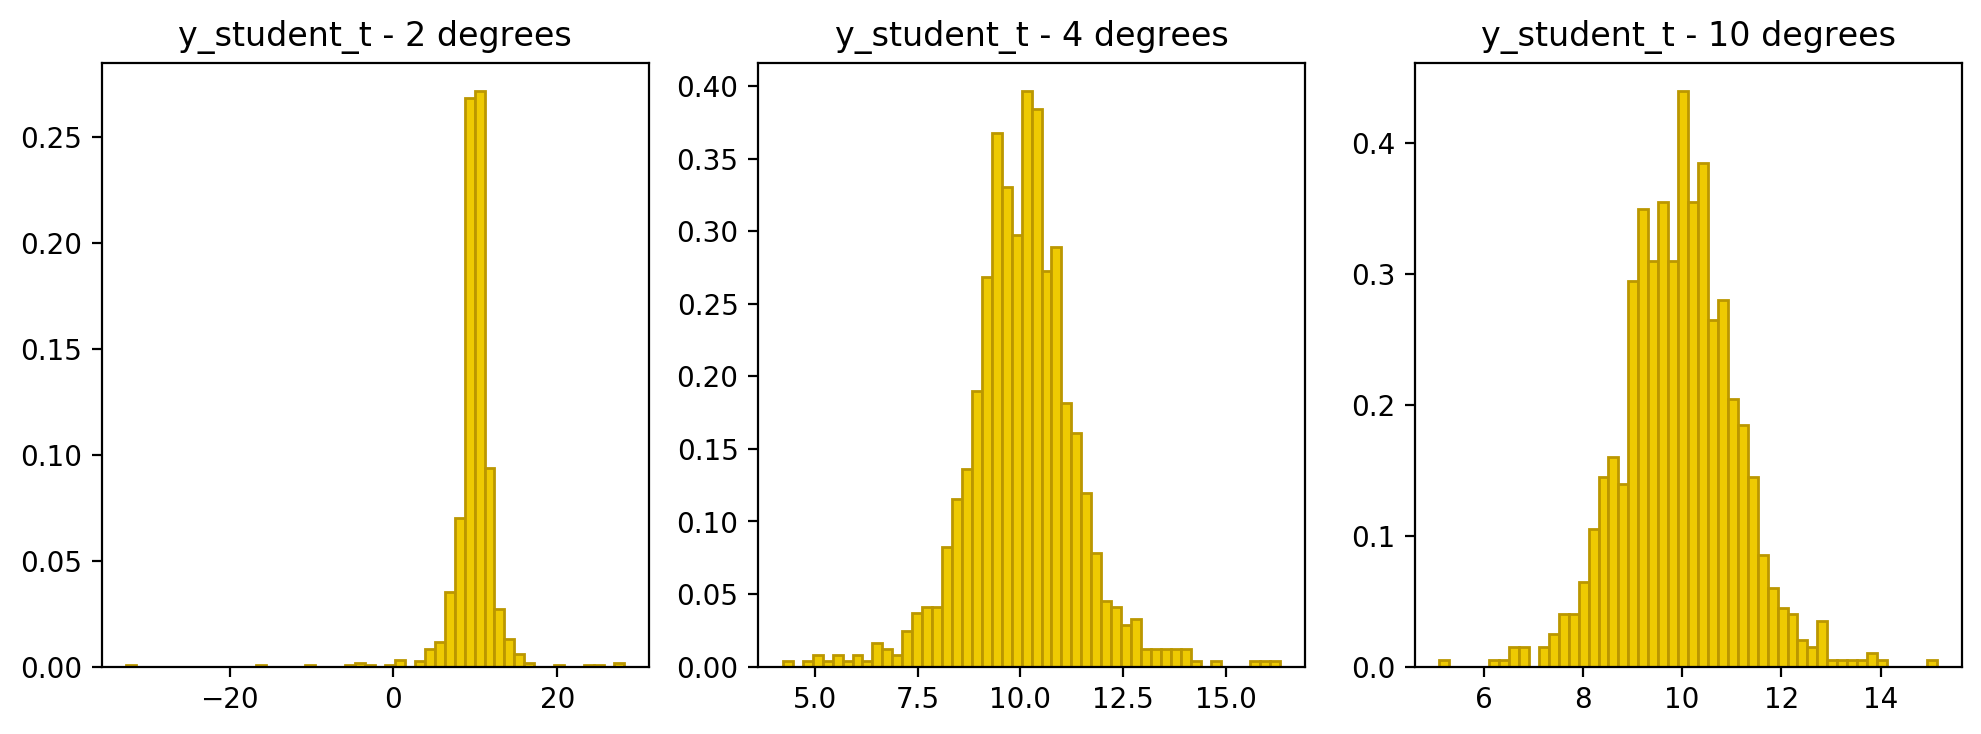

In [139]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
ax1=axes[0]
ax1.hist(y_student_t2,color=dark,edgecolor=dark_highlight,density=True,bins=50)
ax1.set_title('y_student_t - 2 degrees')
ax2=axes[1]
ax2.hist(y_student_t4,color=dark,edgecolor=dark_highlight,density=True,bins=50)
ax2.set_title('y_student_t - 4 degrees')
ax3=axes[2]
ax3.hist(y_student_t10,color=dark,edgecolor=dark_highlight,density=True,bins=50)
ax3.set_title('y_student_t - 10 degrees')
plt.show()

In [140]:
#the more degrees the bigger variance

In [151]:
nu = 1 #degree
mu = 1 #mean
sigma = 1 #variance
sim_data=dict(nu = nu, mu = mu, sigma = sigma)
sim_ppc=model_prior.sampling(data=sim_data,algorithm="Fixed_param", iter=R, warmup=0, chains=1, refresh=R,
                             seed=30042020)
params=sim_ppc.extract()
y_student_t2=params['y_student_t']
mu = 5 #mean
sim_data=dict(nu = nu, mu = mu, sigma = sigma)
sim_ppc=model_prior.sampling(data=sim_data,algorithm="Fixed_param", iter=R, warmup=0, chains=1, refresh=R,
                             seed=30042020)
params=sim_ppc.extract()
y_student_t4=params['y_student_t']
mu = 50 #mean
sim_data=dict(nu = nu, mu = mu, sigma = sigma)
sim_ppc=model_prior.sampling(data=sim_data,algorithm="Fixed_param", iter=R, warmup=0, chains=1, refresh=R,
                             seed=30042020)
params=sim_ppc.extract()
y_student_t10=params['y_student_t']

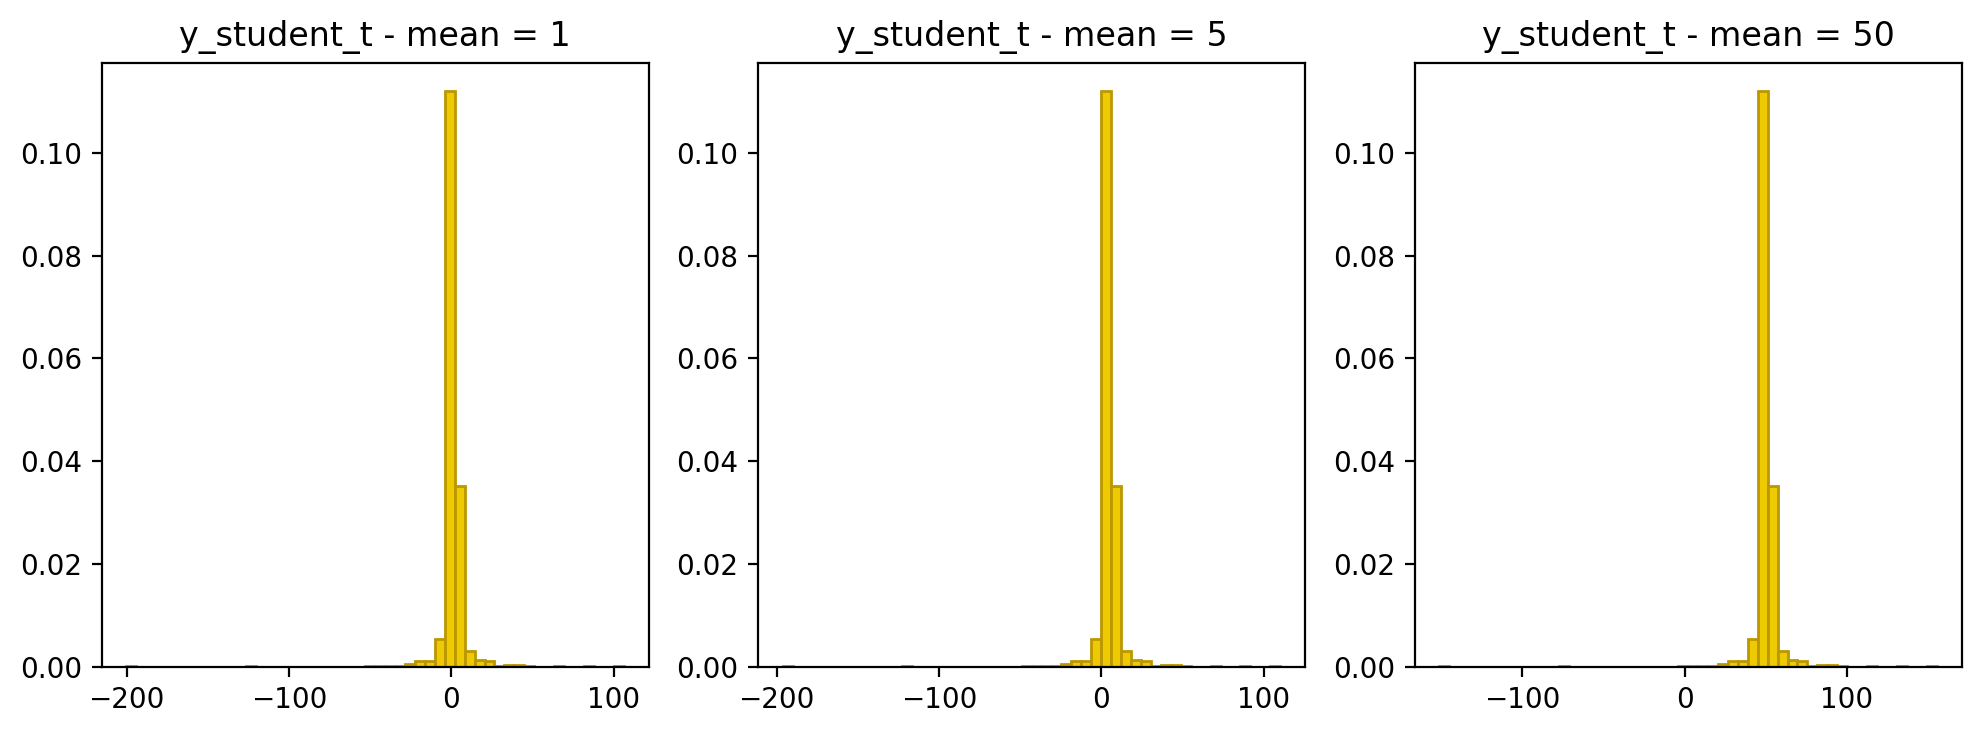

In [152]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
ax1=axes[0]
ax1.hist(y_student_t2,color=dark,edgecolor=dark_highlight,density=True,bins=50)
ax1.set_title('y_student_t - mean = 1')
ax2=axes[1]
ax2.hist(y_student_t4,color=dark,edgecolor=dark_highlight,density=True,bins=50)
ax2.set_title('y_student_t - mean = 5')
ax3=axes[2]
ax3.hist(y_student_t10,color=dark,edgecolor=dark_highlight,density=True,bins=50)
ax3.set_title('y_student_t - mean = 50')
plt.show()

In [ ]:
#The higher mean the higher mean. We can observe that mean grow.

In [149]:
nu = 1 #degree
mu = 10 #mean
sigma = 1 #variance
sim_data=dict(nu = nu, mu = mu, sigma = sigma)
sim_ppc=model_prior.sampling(data=sim_data,algorithm="Fixed_param", iter=R, warmup=0, chains=1, refresh=R,
                             seed=30042020)
params=sim_ppc.extract()
y_student_t2=params['y_student_t']
sigma = 8 #variance
sim_data=dict(nu = nu, mu = mu, sigma = sigma)
sim_ppc=model_prior.sampling(data=sim_data,algorithm="Fixed_param", iter=R, warmup=0, chains=1, refresh=R,
                             seed=30042020)
params=sim_ppc.extract()
y_student_t4=params['y_student_t']
sigma = 20 #variance
sim_data=dict(nu = nu, mu = mu, sigma = sigma)
sim_ppc=model_prior.sampling(data=sim_data,algorithm="Fixed_param", iter=R, warmup=0, chains=1, refresh=R,
                             seed=30042020)
params=sim_ppc.extract()
y_student_t10=params['y_student_t']

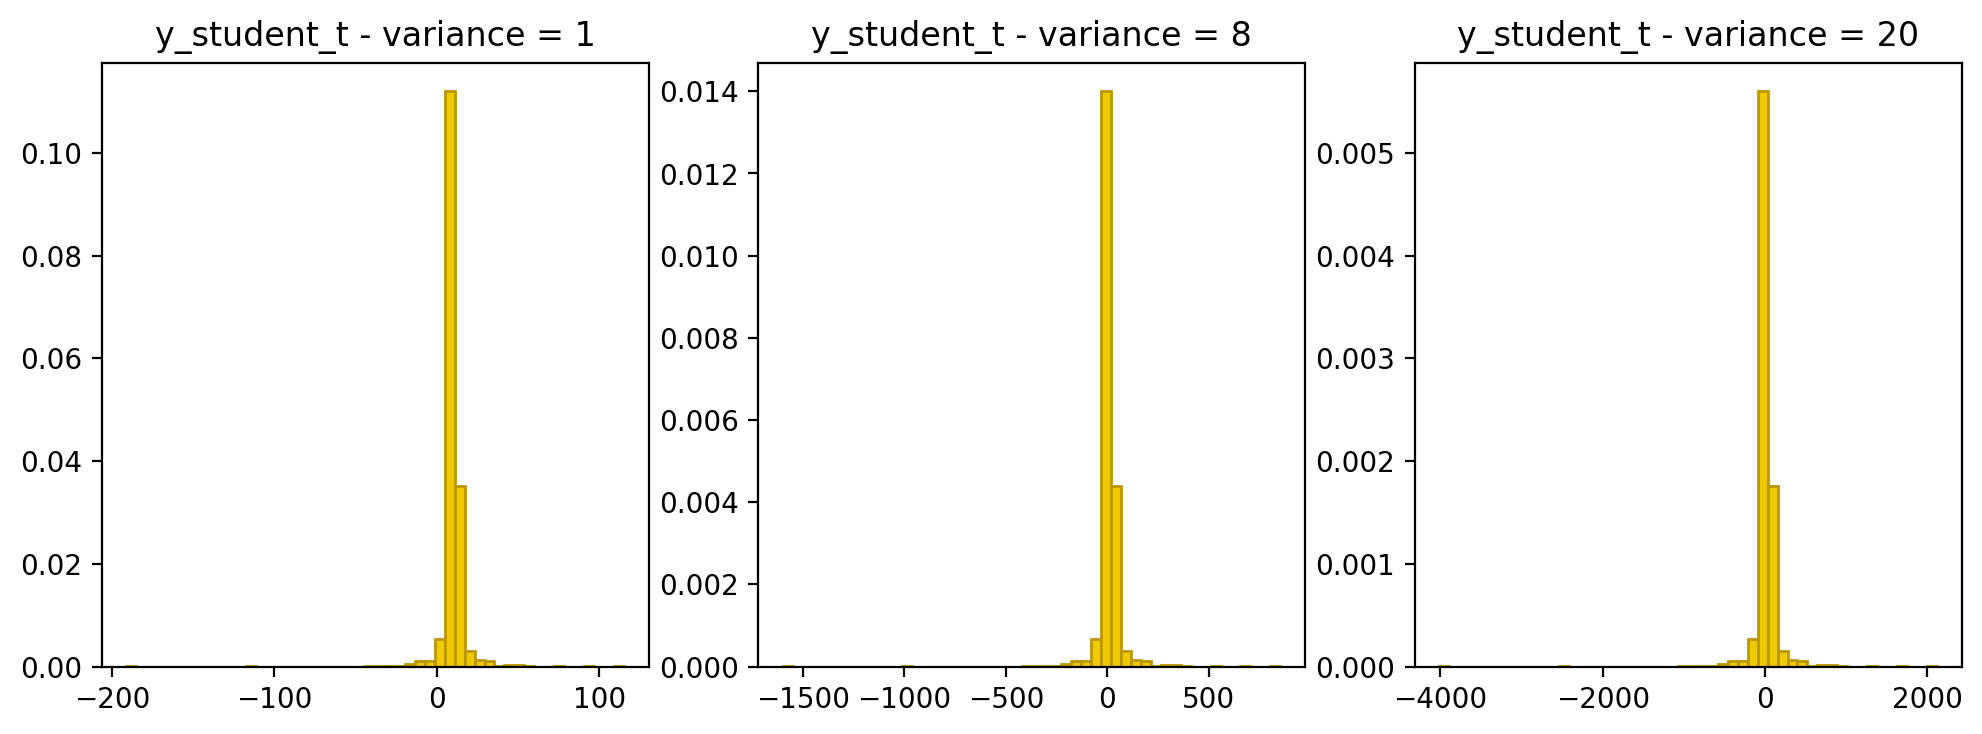

In [150]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
ax1=axes[0]
ax1.hist(y_student_t2,color=dark,edgecolor=dark_highlight,density=True,bins=50)
ax1.set_title('y_student_t - variance = 1')
ax2=axes[1]
ax2.hist(y_student_t4,color=dark,edgecolor=dark_highlight,density=True,bins=50)
ax2.set_title('y_student_t - variance = 8')
ax3=axes[2]
ax3.hist(y_student_t10,color=dark,edgecolor=dark_highlight,density=True,bins=50)
ax3.set_title('y_student_t - variance = 20')
plt.show()

In [153]:
#We can observe that variance grows with higher variance parameter

In [154]:
R = 100
nu = 1 #degree
mu = 10 #mean
sigma = 1 #variance
sim_data=dict(nu = nu, mu = mu, sigma = sigma)
sim_ppc=model_prior.sampling(data=sim_data,algorithm="Fixed_param", iter=R, warmup=0, chains=1, refresh=R,
                             seed=30042020)
params=sim_ppc.extract()
y_student_t2=params['y_student_t']
R = 1000
sim_data=dict(nu = nu, mu = mu, sigma = sigma)
sim_ppc=model_prior.sampling(data=sim_data,algorithm="Fixed_param", iter=R, warmup=0, chains=1, refresh=R,
                             seed=30042020)
params=sim_ppc.extract()
y_student_t4=params['y_student_t']
R = 10000
sim_data=dict(nu = nu, mu = mu, sigma = sigma)
sim_ppc=model_prior.sampling(data=sim_data,algorithm="Fixed_param", iter=R, warmup=0, chains=1, refresh=R,
                             seed=30042020)
params=sim_ppc.extract()
y_student_t10=params['y_student_t']

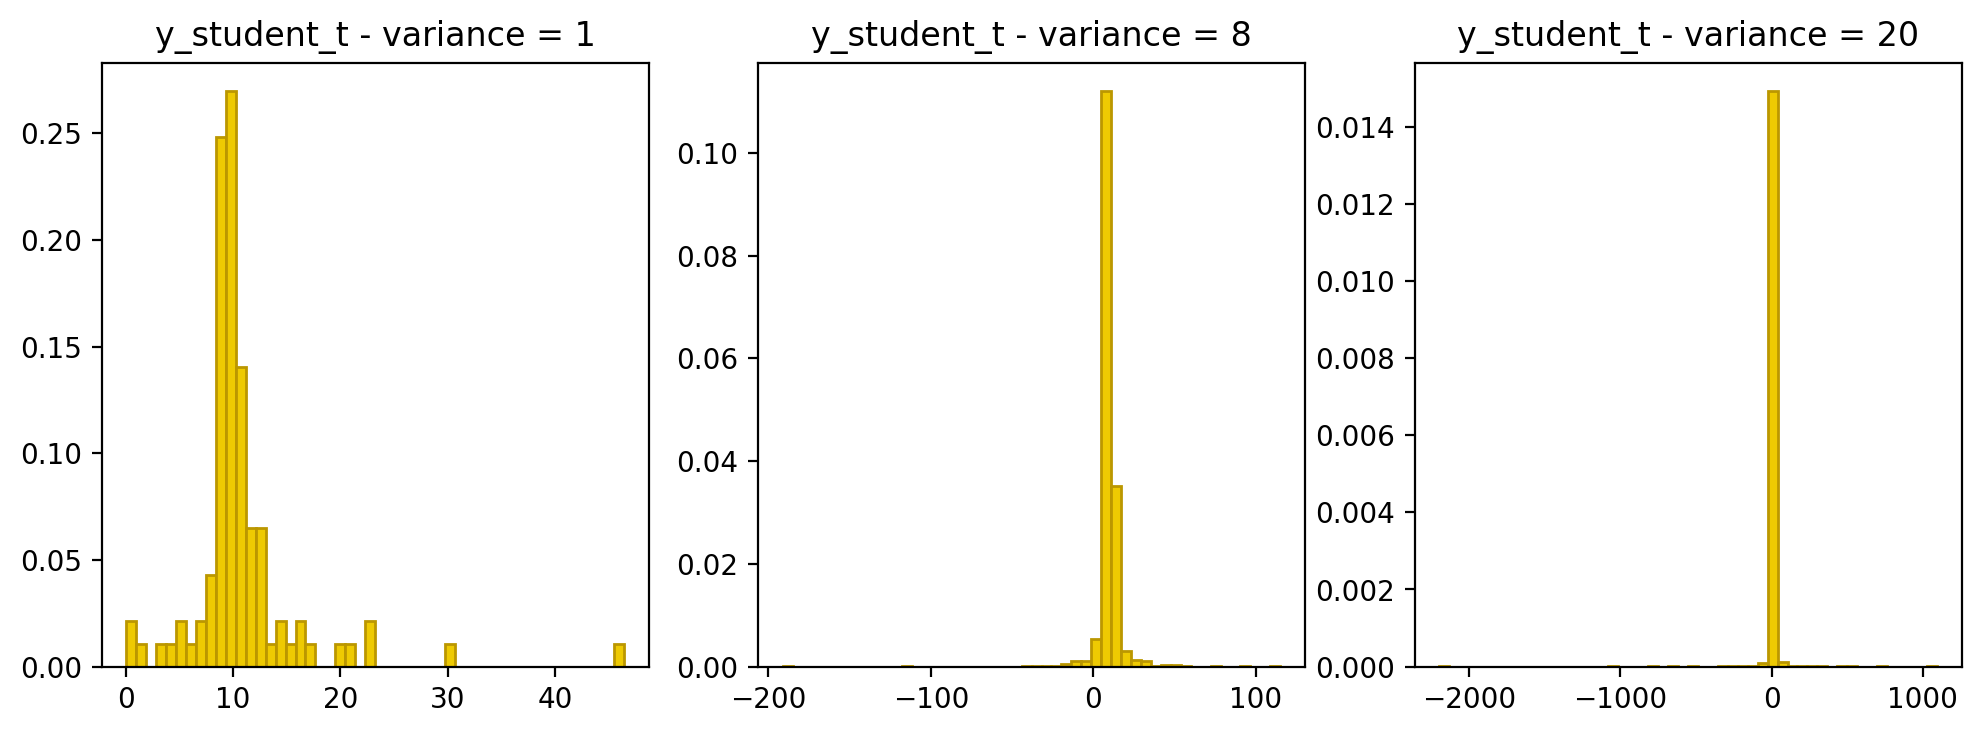

In [155]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
ax1=axes[0]
ax1.hist(y_student_t2,color=dark,edgecolor=dark_highlight,density=True,bins=50)
ax1.set_title('y_student_t - variance = 1')
ax2=axes[1]
ax2.hist(y_student_t4,color=dark,edgecolor=dark_highlight,density=True,bins=50)
ax2.set_title('y_student_t - variance = 8')
ax3=axes[2]
ax3.hist(y_student_t10,color=dark,edgecolor=dark_highlight,density=True,bins=50)
ax3.set_title('y_student_t - variance = 20')
plt.show()

In [156]:
#The more iterations the more values at mean value. With more iterations we have higher chance for value far away from mean.

In [ ]:
# Multivariate normal distributions.

In [157]:
with open('multivar_normal.stan', 'r') as file:
    print(file.read())

data {
    int<lower=0> n;
    vector[n] mu; //location vector
    matrix[n,n] sigma; //covariance matrix
}

parameters {
    vector[n] y;
}

model {
    y ~ multi_normal(mu, sigma);
}


In [160]:
model_prior=stan_utility.compile_model('multivar_normal.stan')

Using cached StanModel


In [161]:
#Definitions of correlation and covariance matrixes
def cov2corr(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

def corr2cov(correlation,SD): #SD - standard deviation
    outer_SD = np.outer(SD, SD)
    covariance = outer_SD*correlation
    return covariance

In [166]:
correlation_matrix = [(0.8,0.4),(0.4,0.8)]
SD = [1,3]
covariance_matrix = corr2cov(correlation_matrix,SD)
print(covariance_matrix)

[[0.8 1.2]
 [1.2 7.2]]


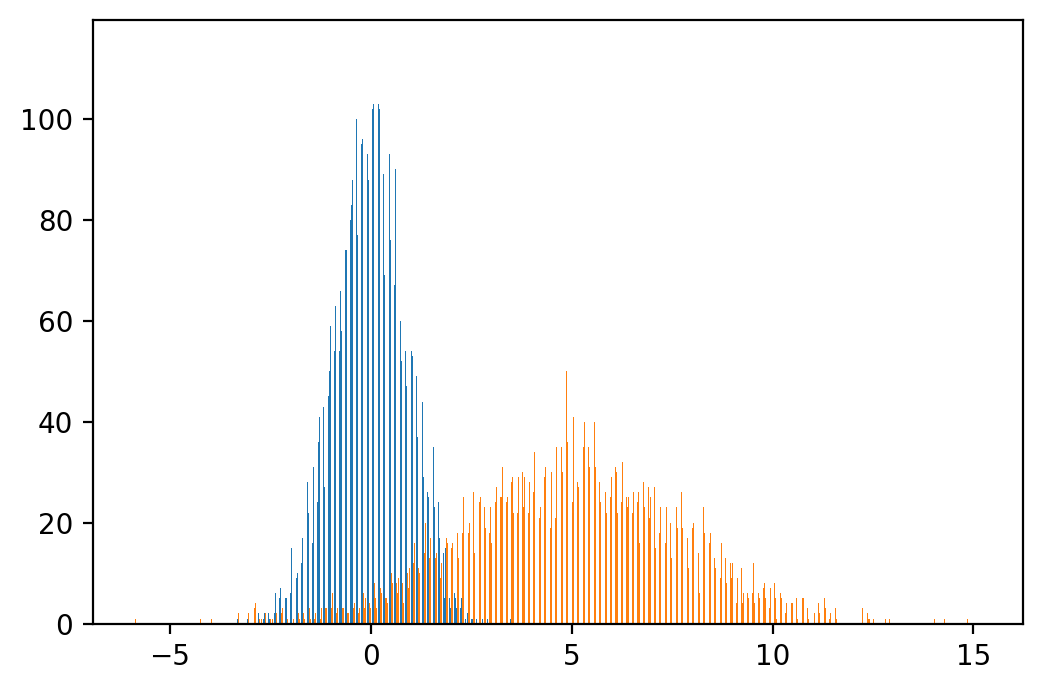

In [169]:
R = 5000
sim_data=dict(n=2, mu=[0, 5], sigma=covariance_matrix)
sim_ppc=model_prior.sampling(data=sim_data, iter=R, seed=30042020)

params=multiNormal_sample.extract()

# Two dimensional standard histogram
hist1=plt.hist(params['y'], bins=1000)

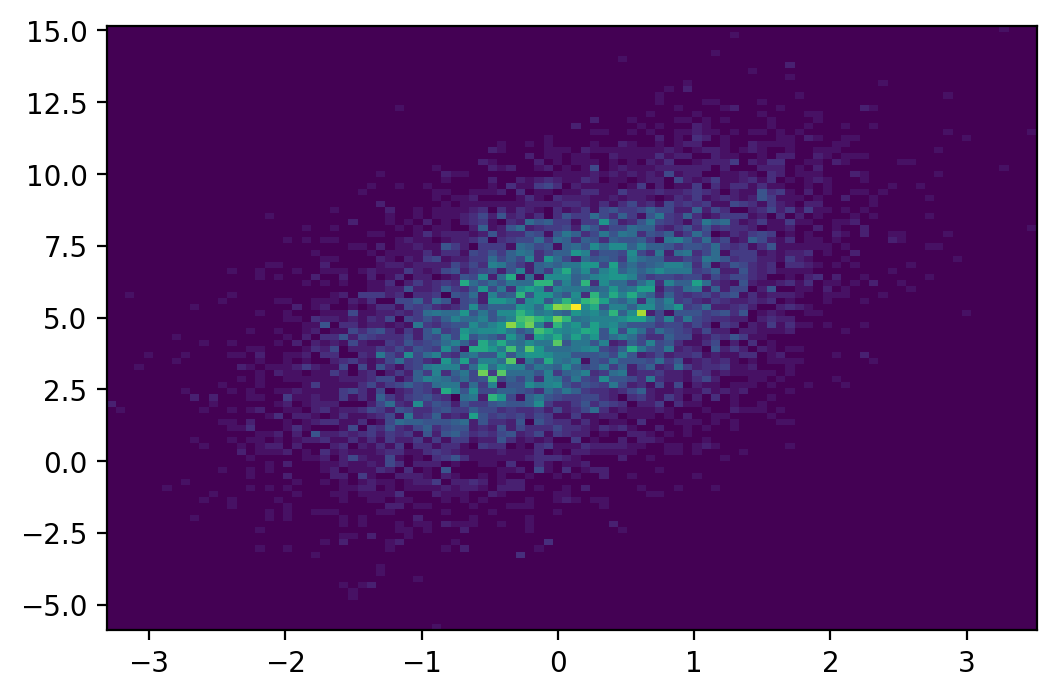

In [170]:
# Two dimensional 2d histogram
hist2=plt.hist2d(params['y'][:,0],params['y'][:,1],bins=100)

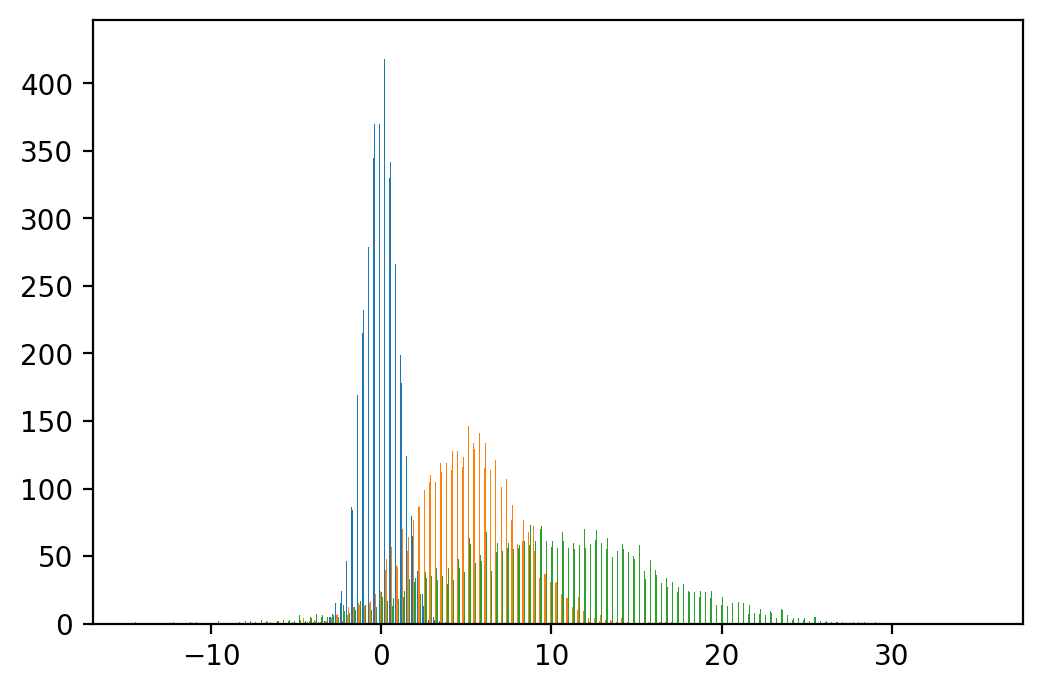

In [184]:
correlation_matrix = [(1,0.5,0.3),(0.5,1,0.5),(0.3,0.5,1)]
SD = [1,3,6]
covariance_matrix = corr2cov(correlation_matrix,SD)
sim_data=dict(n=3, mu=[0, 5,10], sigma=covariance_matrix)

R = 10000
sim_ppc=model_prior.sampling(data=sim_data, iter=R, seed=30042020)
params=sim_ppc.extract()

# Three dimensional standard histogram
hist3=plt.hist(params['y'], bins=1000)

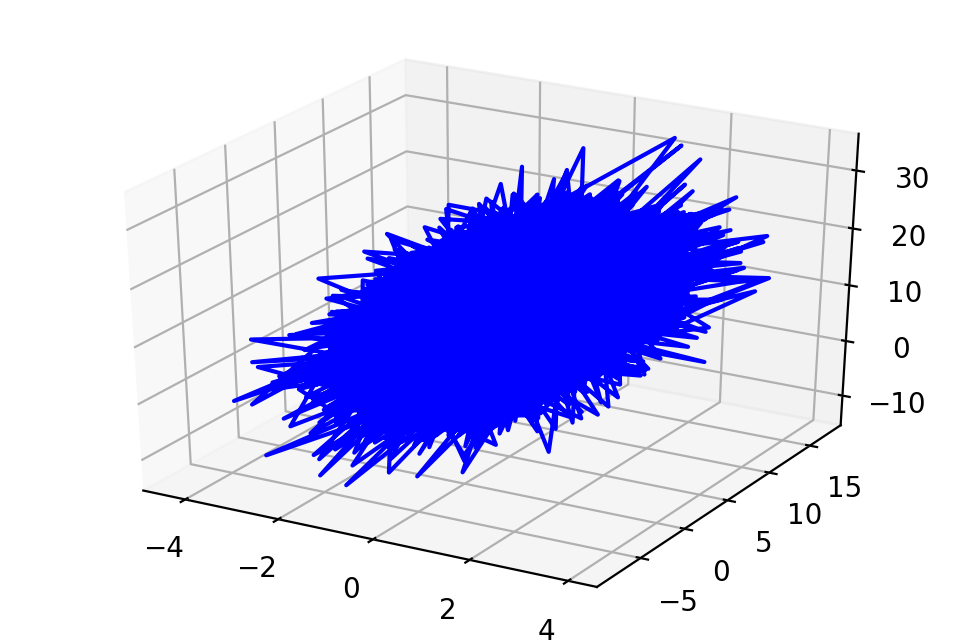

In [186]:
from mpl_toolkits import mplot3d

fig = plt.figure()
ax = plt.axes(projection='3d')

# Three dimensional 3d histogram
ax.plot3D(params['y'][:,0], params['y'][:,1], params['y'][:,2], 'blue')

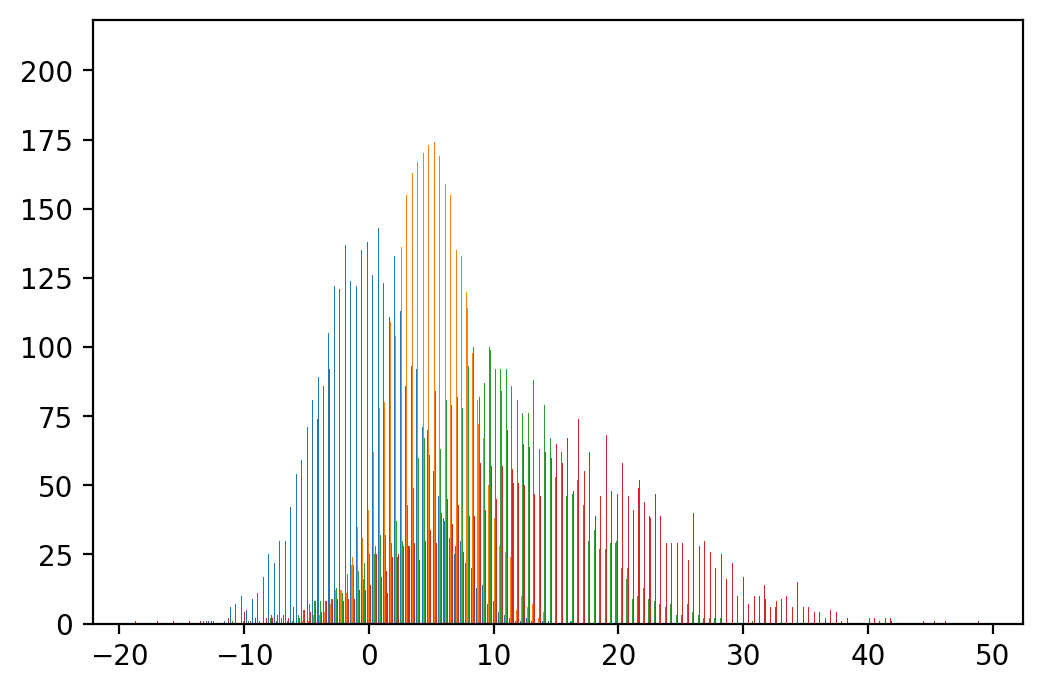

In [190]:
correlation_matrix = [(1,0.2,0.3,0.4),(0.2,1,0.5,0.6),(0.3,0.5,1,0.7),(0.4,0.6,0.7,1)]
SD = [4,3,6,9]
covariance_matrix = corr2cov(correlation_matrix,SD)
sim_data=dict(n=4, mu=[0, 5, 10, 15], sigma=covariance_matrix)

R = 10000
sim_ppc=model_prior.sampling(data=sim_data, iter=R, seed=30042020)
params=sim_ppc.extract()

# Four dimensional standard histogram
hist3=plt.hist(params['y'], bins=1000)